# Simba Spectra

Here we test VAMP on a synthetic spectrum of a massive central galaxy in the s43 Simba simulation, generated using [Pygad](https://bitbucket.org/broett/pygad/src/master/) for the CII 1036 Angstrom line.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from vpfits import *
from physics import *

import h5py

import corner

## Carbon Spectrum

First we will fit a metal spectrum. Load in the dataset and extract the data:

In [3]:
carbon_line = 1036. # angstroms

carbon_data = h5py.File('data/simba_CII1036.h5', 'r')
carbon_data.keys()

[u'density_col',
 u'flux',
 u'noise',
 u'tau',
 u'temp',
 u'velocity',
 u'wavelength']

In [4]:
carbon_wavelength = carbon_data['wavelength'][:]
carbon_flux = carbon_data['flux'][:]
carbon_noise = carbon_data['noise'][:]
carbon_taus = carbon_data['tau'][:]

carbon_nu = constants['c']['value'] / carbon_wavelength 

### Region Detection

Next we find the regions in the spectrum that have absorption features to fit. The `min_region_width` argument sets the minimum width of a region in pixels.

In [5]:
min_region_width = 2
carbon_regions, carbon_region_pixels = compute_detection_regions(carbon_wavelength, carbon_flux, 
                                                                 carbon_noise, min_region_width=2)

Computing detection regions...
Found 4 detection regions.


Plot the spectrum to see the regions we've identified:

In [6]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

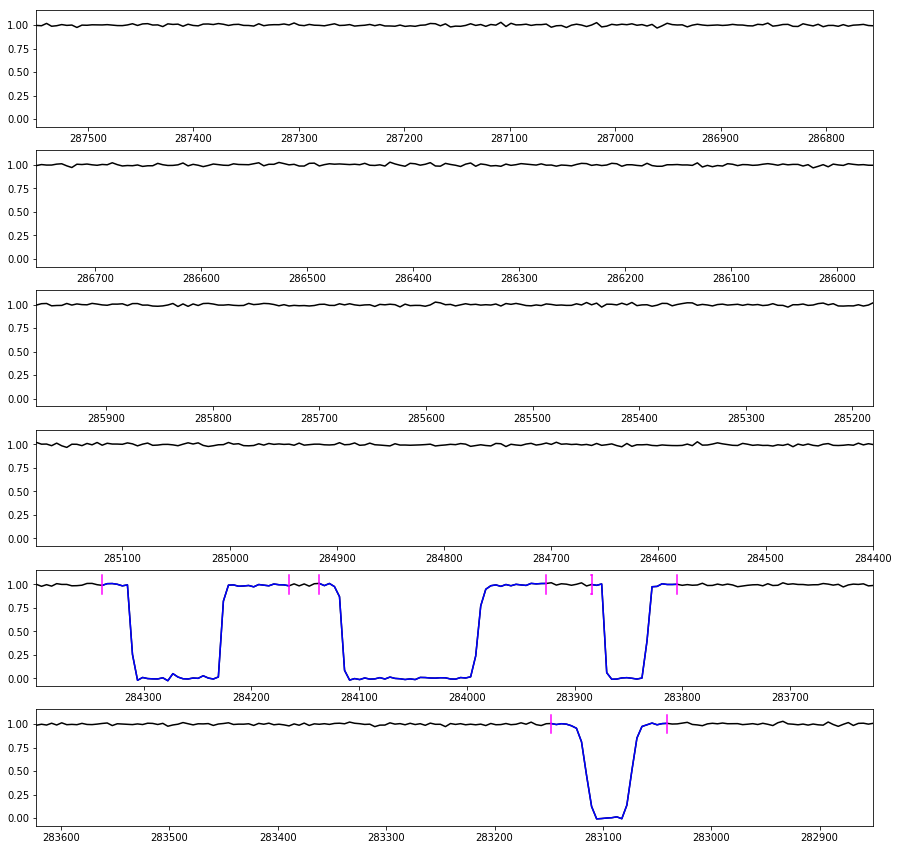

In [7]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(carbon_flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(carbon_nu, carbon_flux, c='black')
    
    ax[n].set_xlim(carbon_nu[lower_lim], carbon_nu[upper_lim])

    for (start, end) in carbon_region_pixels:
        ax[n].plot(carbon_nu[start:end+1], carbon_flux[start:end+1], color='blue')
        plot_bracket(carbon_nu[start], ax[n], 'left')
        plot_bracket(carbon_nu[end], ax[n], 'right')

plt.show()

### Fitting

Now we will fit each region individually. 

VAMP makes an initial guess as to the number of local minima in each region. It then does a Bayesian MCMC fit of a Gaussian or Voigt profile using the initial guess and sees how well it matches the data by calculating the Bayesian Information Criterion (BIC) and the Chi-squared of the fit. VAMP will then find the optimal number of minima by increasing the number of profiles iteratively and looking at the BIC and the Chi-squared of the fit.

Fitting the spectrum gives us an amplitude, width and position for each of the profiles in the region, which can be used to find the optical depth, Doppler b parameter and equivalent width of each profile.

A length of 3000 iterations is enough to get a good fit to the data, but here we exaggerate it and do 5000 iterations so that we can see the contours in the parameter 2d histograms properly.

Setting initial number of lines to: 1
Old BIC value of -34.84 is greater than the current -55.70.
Increasing the number of lines to: 3
Old BIC value of -55.70 is greater than the current -148.85.
Increasing the number of lines to: 4
Old BIC value of -148.85 is greater than the current -169.92.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


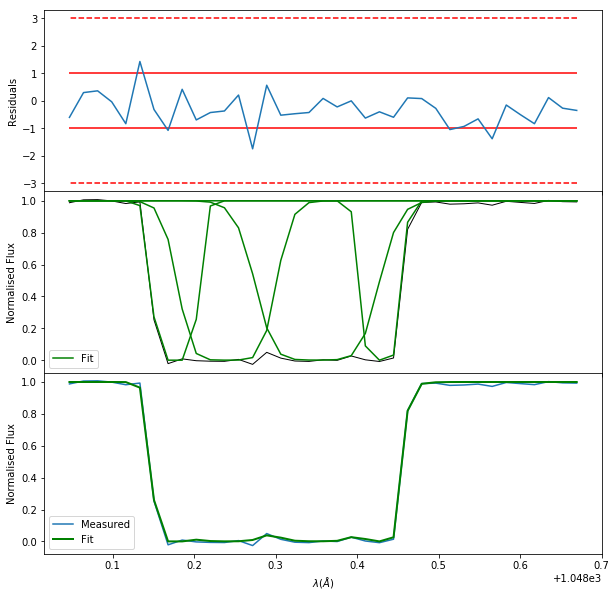

Setting initial number of lines to: 1
Old BIC value of -42.51 is greater than the current -80.43.
Increasing the number of lines to: 3
Old BIC value of -80.43 is greater than the current -227.42.
Increasing the number of lines to: 4
Old BIC value of -227.42 is greater than the current -240.51.
Reduced Chi squared is less than 1.0
Final n=4


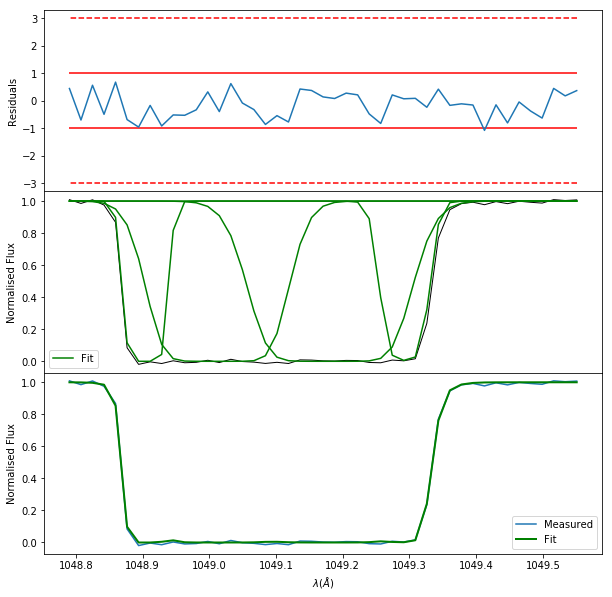

Setting initial number of lines to: 1
Old BIC value of -13.28 is greater than the current -52.89.
Increasing the number of lines to: 3
Old BIC value of -52.89 is greater than the current -76.64.
Increasing the number of lines to: 4
BIC increased with increasing the line number, stopping.
Final n=3.


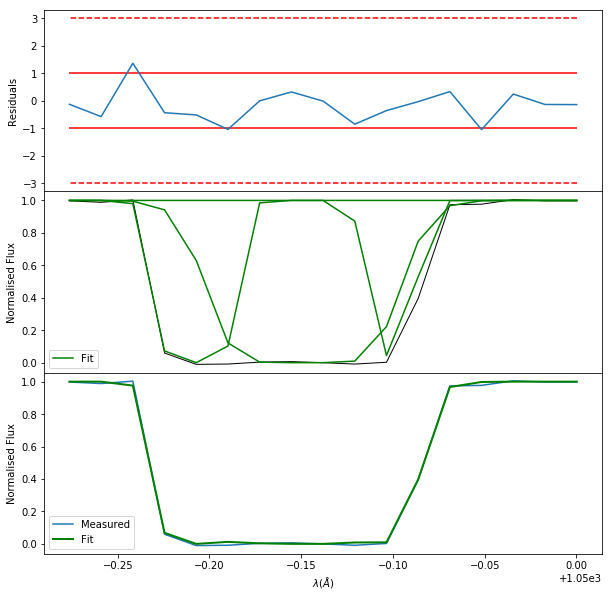

Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


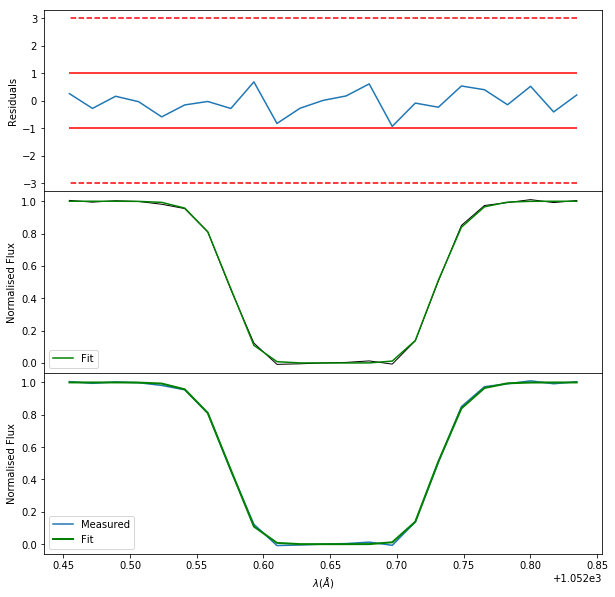

In [10]:
for start, end in carbon_region_pixels:
    carbon_waves = np.flip(carbon_wavelength[start:end], 0)
    carbon_fluxes = np.flip(carbon_flux[start:end], 0)
    carbon_nus = np.flip(carbon_nu[start:end], 0)
    carbon_noises = np.flip(carbon_noise[start:end], 0)

    n = estimate_n(carbon_fluxes)
    freedom = len(carbon_nus) - 3*n
    carbon = region_fit(carbon_nus, carbon_fluxes, n, carbon_noises, freedom, iterations=5000, burn=500)
    n = len(carbon.estimated_profiles)
    carbon.plot(carbon_waves, carbon_fluxes, n=n, start_pix=start, end_pix=end)
    

We can look at the chains used for the fitting and see if we have sensible distributions for the parameters:

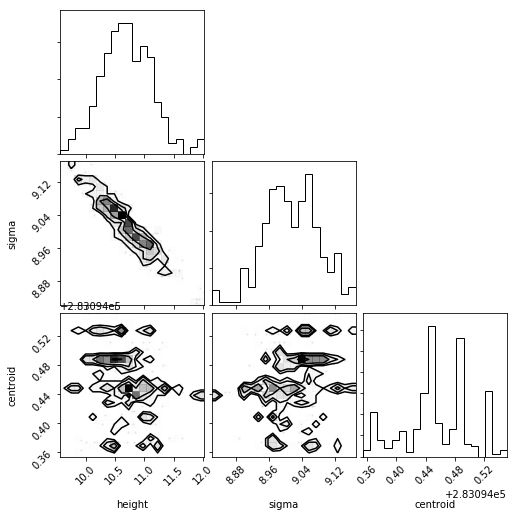

In [11]:
height = carbon.mcmc.trace(carbon.estimated_variables[0]['amplitude'])[:]
sigma = carbon.mcmc.trace(carbon.estimated_variables[0]['sigma'])[:]
centroid = carbon.mcmc.trace(carbon.estimated_variables[0]['centroid'])[:]

samples = np.transpose(np.array([height, sigma, centroid]))

fig = corner.corner(samples, labels=['height', 'sigma', 'centroid'])

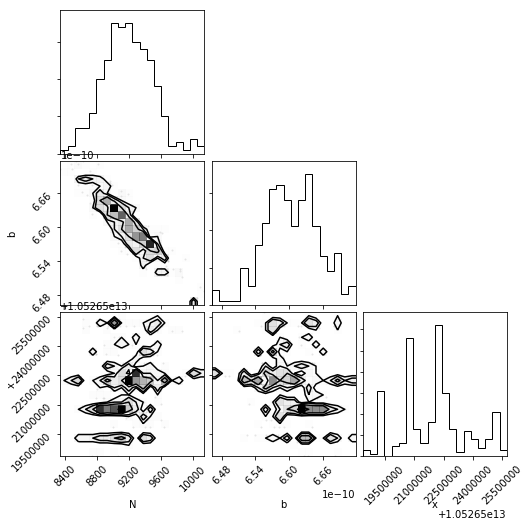

In [12]:
carbon_b = DopplerParameter(sigma, carbon_line)
carbon_N = ColumnDensity(height, sigma)

l_centroid = Freq2wave(centroid)

phys_samples = np.transpose(np.array([carbon_N, carbon_b, l_centroid]))
fig = corner.corner(phys_samples, labels=['N', 'b', 'x'])

## Hydrogen Spectrum

Now we will fit a Hydrogen spectrum, which requires a Voigt profile instead of a Gaussian. The extra parameter in the Voigt profile means this is slower than fitting a Gaussian.

In general, the Gaussian fit is much faster (the extra parameter makes a huge difference!) so whenever possible it's better to just use a Gaussian.

In [13]:
hydro_line = 1215.

hydro_data = h5py.File('data/simba_H1215.h5', 'r')

hydro_wavelength = hydro_data['wavelength'][:]
hydro_flux = hydro_data['flux'][:]
hydro_noise = hydro_data['noise'][:]
hydro_taus = hydro_data['tau'][:]

hydro_nu = constants['c']['value'] / hydro_wavelength 

In [14]:
# Identify regions in the spectrum to fit

min_region_width = 2
hydro_regions, hydro_region_pixels = compute_detection_regions(hydro_wavelength, hydro_flux, 
                                                               hydro_noise, min_region_width=min_region_width)

Computing detection regions...
Found 3 detection regions.


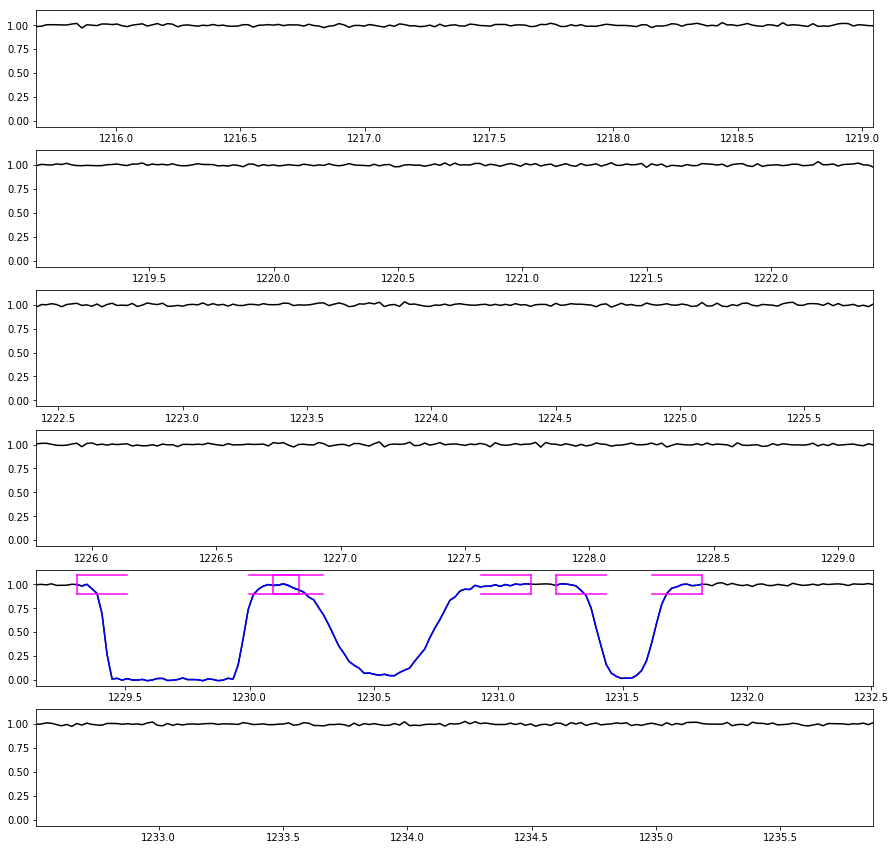

In [15]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(hydro_flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(hydro_wavelength, hydro_flux, c='black')
    
    ax[n].set_xlim(hydro_wavelength[lower_lim], hydro_wavelength[upper_lim])

    for (start, end) in hydro_region_pixels:
        ax[n].plot(hydro_wavelength[start:end+1], hydro_flux[start:end+1], color='blue')
        plot_bracket(hydro_wavelength[start], ax[n], 'left')
        plot_bracket(hydro_wavelength[end], ax[n], 'right')

plt.show()

Setting initial number of lines to: 1
Old BIC value of -2.81 is greater than the current -16.67.
Increasing the number of lines to: 3
Old BIC value of -16.67 is greater than the current -34.61.
Increasing the number of lines to: 4
BIC increased with increasing the line number, stopping.
Final n=3.


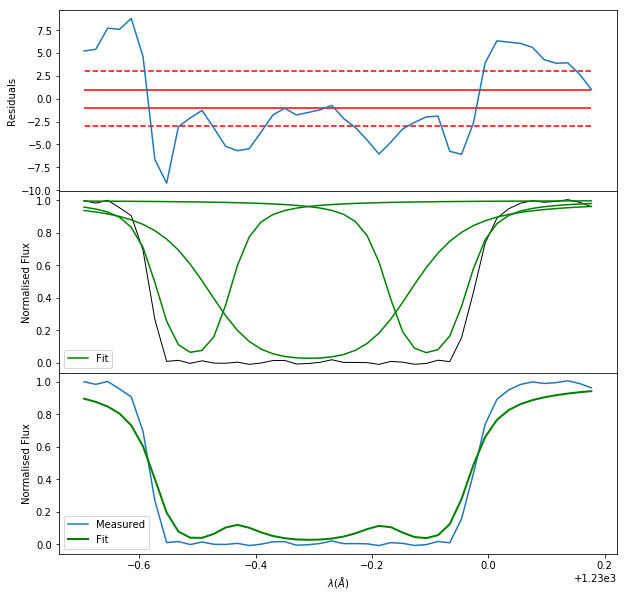

Setting initial number of lines to: 1
Old BIC value of -261.69 is greater than the current -270.45.
Increasing the number of lines to: 3
BIC increased with increasing the line number, stopping.
Final n=2.


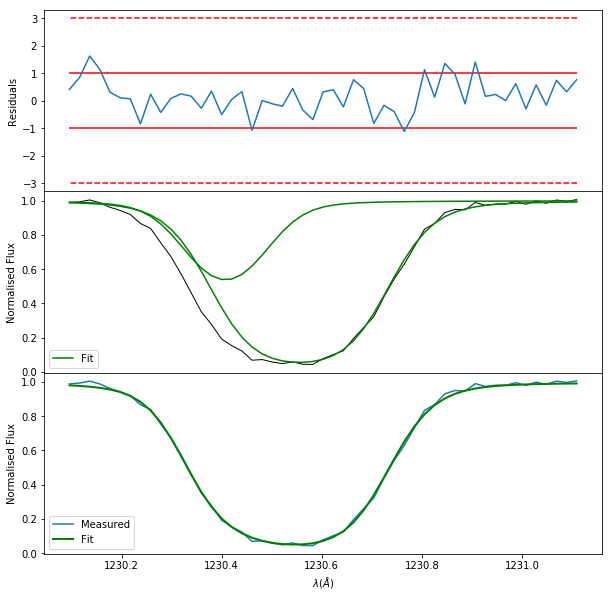

Setting initial number of lines to: 1
Old BIC value of -120.42 is greater than the current -124.06.
Increasing the number of lines to: 3
BIC increased with increasing the line number, stopping.
Final n=2.


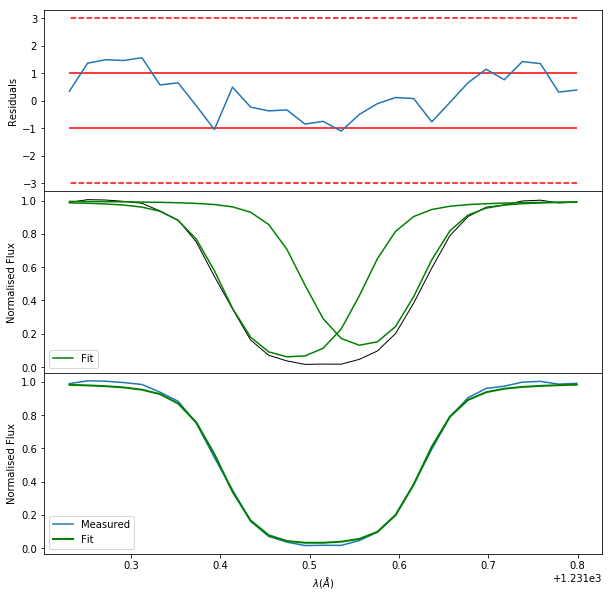

In [16]:
for start, end in hydro_region_pixels:
    hydro_waves = np.flip(hydro_wavelength[start:end], 0)
    hydro_fluxes = np.flip(hydro_flux[start:end], 0)
    hydro_nus = np.flip(hydro_nu[start:end], 0)
    hydro_noises = np.flip(hydro_noise[start:end], 0)

    n = estimate_n(hydro_fluxes)
    freedom = len(hydro_nus) + 3
    hydro = region_fit(hydro_nus, hydro_fluxes, n, hydro_noises, freedom, voigt=True)
    n = len(hydro.estimated_profiles)
    hydro.plot(hydro_waves, hydro_fluxes, n=n, start_pix=start, end_pix=end)
    

It's clear from the plots that a Voigt profile is not a good choice for saturated lines, where the sides of the profile are steep.